<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction


The bounded lognorm is a continuous propbability distribution related to the [normal](https://en.wikipedia.org/wiki/Normal_distribution) and [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) distributions. Whereas the lognormal probability density function has a lower bound, the bounded lognorm has a lower and upper bound.

The bounded lognorm is fully defined by four parameters: mode $m$, standard deviation $\sigma$, lower, and upper.

$blognorm.pdf(x, m, \sigma, lower, upper) =
  \begin{cases}
    lognormal.pdf(x, m, \sigma)   &  \text{if } x <= m \\
    lognormal.pdf(upper-x, upper-m, \sigma)   &  \text{if } x > m \\
  \end{cases}
$

The bounded lognorm is implemented in python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

### Imports and Class Definition

In [0]:
from scipy.stats import rv_continuous, rv_discrete, norm, lognorm
from scipy.integrate import quad, cumtrapz, trapz
from scipy import interpolate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]

In [0]:
def lognorm_pdf(x, mu_N, sigma_N):
    '''
    Log-normal (aka lognormal) probability density function.
    
    Parameters
    ----------
    mu_N : float: mean of underlying normal distribution
    sigma_N : float: standard deviation of underlying normal distribution
    
    Returns
    -------
    array of floats
    
    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    '''
    
    a = 1 / (x * sigma_N * np.sqrt(2 * np.pi)) 
    b = np.exp(-(np.log(x) - mu_N)**2 / (2 * sigma_N**2))
    y = a * b
    return y


def lognorm_params(mode, sigma):
    '''
    Given user-defined mode and sigma of a lognormal distribution, 
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float: mode of lognormal distribution
    sigma : float: standard deviation of lognormal distribution
    
    Returns
    -------
    mu_N : float
    sigma_N : float
    
    References
    ----------
    [1] Adapted from Warren Weckesser's ansnwer to 
        https://stackoverflow.com/questions/41464753
    '''
        
    # find the roots of the polynomial
    # g^4 - g^3 - sigma^2/mode^2
    # where g = exp(variance of the associated Normal distribution)
    p = np.poly1d([1, -1, 0, 0, -(sigma/mode)**2])
    r = p.roots 
    
    # just the real, positive root
    solution = r[(r.imag == 0) & (r.real > 0)].real
    
    sigma_N = np.sqrt(np.log(solution))
    mu_N = np.log(mode * solution)
    return mu_N, sigma_N


class bounded_lognorm_gen(rv_continuous):
    '''
    Subclass of scipy.stats.rv_continuous. This is used to generate a
    bounded lognormal continuous probability distribution, which is  fully 
    described by mode, standard deviation (sigma), lower, and upper bounds.

    The probability density function (pdf) concatenates two lognormal pdf:
    1. left of mode: lognormal pdf with loc at lower bound, and 
    2. right of mode: reversed lognormal pdf with loc at upper bound and 
        scaled so that the concatenated pdf is continuous at the mode.

    Methods
    -------
    same as scipy.stats.rv_continuous
    '''

    def _pdf(self, x, mode, sigma, lower, upper):
        '''
        Probability density function (pdf)

        Parameters
        ----------
        x : float, list or array of floats; x-value(s)
        mode : float; mode
        sigma : float; standard deviation
        lower : float; lower bound 
        upper : float; upper bound 

        Returns
        -------
        relative likelihood [1] of x

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Probability_density_function
        '''
        
        # converts to numpy array if x is a scalar or list
        if not isinstance(x, (pd.core.series.Series, np.ndarray)):
            x = np.array([x])

        # shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # concatenations left- and right-of-mode pdfs
        y = self.concat_pdf(x, mode, sigma, upper)
        
        # normalizes concatenated pdf to area = 1
        if hasattr(x, "__len__") and len(x) >= 1000:
            scale = trapz(y, x)
        else:    
            scale, _ = quad(lambda j: self.concat_pdfs(j, mode, sigma, upper), 
                            0, upper)
        return y / scale
    
    def _cdf(self, x, mode, sigma, lower, upper):
        '''
        Cumulative density function (cdf)
        '''
        x_, y_ = self.discrete_cdf(x, mode, sigma, lower, upper)
        return interpolate.interp1d(x_, y_, axis=0)(x)

    def _ppf(self, p, mode, sigma, lower, upper):
        '''
        Percent point function (ppf), inverse of cdf
        '''
        x_, y_ = self.discrete_cdf(p, mode, sigma, lower, upper)
        return interpolate.interp1d(y_, x_, axis=0, bounds_error=False,
                                    fill_value=(lower, upper))(p) 
           
    '''def _stats(self, mode, sigma, lower, upper):
        p = np.exp(s*s)
        mu = np.sqrt(p)
        mu2 = p*(p-1)
        g1 = np.sqrt((p-1))*(2+p)
        g2 = np.polyval([1, 2, 3, 0, -6.0], p)
        return mu, mu2, g1, g2'''
    
    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns 
        condition array of 1s where arguments are correct and 0s where they 
        are not.
        """

        for arg in args:
            cond = np.isfinite(arg)
        return cond
    
    def pdf(self, x, mode, sigma, lower, upper):
        # converts parameters to scalars, if necessary
        try:
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass  
        return self._pdf(x, mode, sigma, lower, upper)
    
    def cdf(self, x, mode, sigma, lower, upper):
        return self._cdf(x, mode, sigma, lower, upper)

    def ppf(self, p, mode, sigma, lower, upper):       
        y = np.where(p == 1.0, 
                     upper,
                     self._ppf(p, mode, sigma, lower, upper))
        return y
    
    def concat_pdf(self, x, mode, sigma, upper):
        '''
        Concatenations left- and right-of-mode pdfs.
        '''
        
        # left side
        muNL, sigmaNL = lognorm_params(mode, sigma)
        xL = np.append(x[x<=mode], [mode], axis=0)
        yL = np.where(xL>0, ln_pdf(xL, muNL, sigmaNL), 0)
        
        # right side
        muNR, sigmaNR = lognorm_params((upper - mode), sigma)
        xR = np.append(x[x>mode], [mode], axis=0)
        yR = np.where(upper - xR > 0, ln_pdf(upper - xR, muNR, sigmaNR), 0)
        
        # scale right side so that left and right sides continuous at mode
        yR = yR * yL[-1]/yR[-1] 
        y = np.append(yL[:-1], yR[:-1], axis=0)
        return y
    
    def discrete_cdf(self, x, mode, sigma, lower, upper, min_samples=1000):
        if hasattr(x, "__len__") and len(x) > min_samples:
            min_samples = len(x)
        x_ = np.linspace(lower, upper, min_samples, endpoint=True) 
        x_ = x_.squeeze()
        y = self._pdf(x_, mode, sigma, lower, upper)
        y_ = cumtrapz(y, x_, initial = 0)
        return x_, y_
       
bounded_lognorm = bounded_lognorm_gen(name='bounded_lognorm', 
                                      shapes='mode, sigma, lower, upper')

### Example Usage

Probability density function (pdf) with 95% confidence interval.

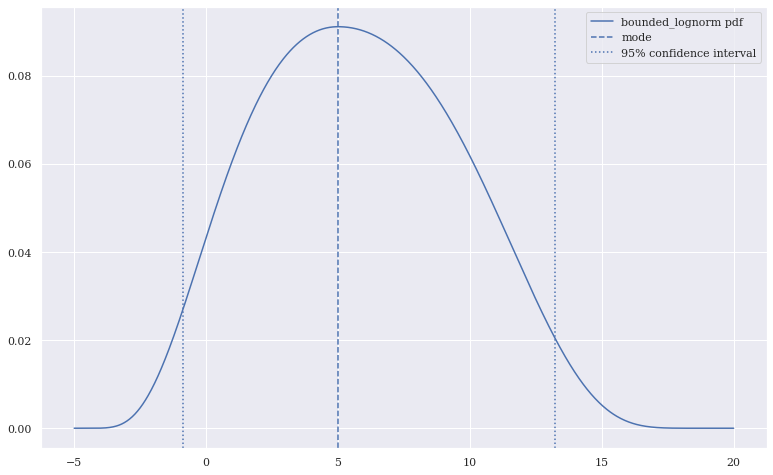

In [369]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded_lognorm pdf')
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted', 
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')

plt.legend()
plt.show()

In [375]:
%timeit -r 3 bounded_lognorm.pdf(x, mode, sigma, lower, upper)

1000 loops, best of 3: 389 µs per loop


Cumulative distribution function (cdf)

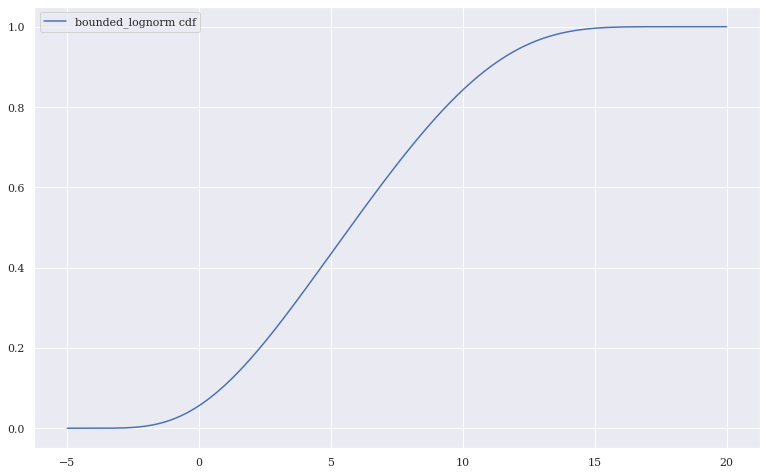

In [370]:
x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded_lognorm cdf')

Percent point function (ppf), the inverse of the cdf.

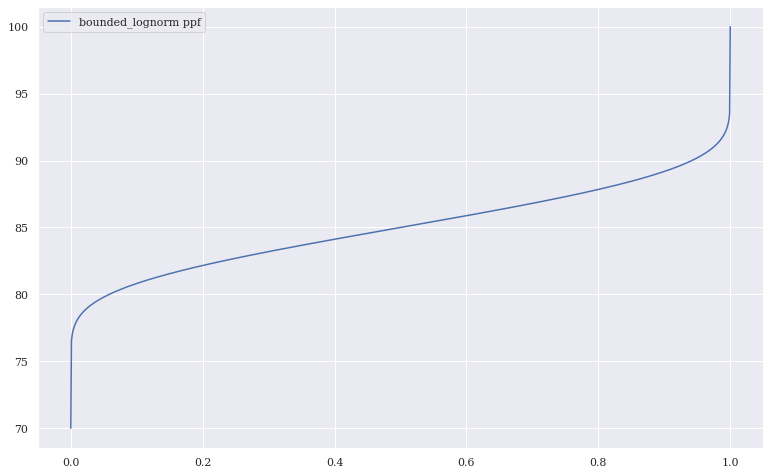

In [371]:
x = np.linspace(0, 1, 1000)
y = bounded_lognorm.ppf(x, mode=85, sigma=5, lower=70, upper=100)
sns.lineplot(x, y, label='bounded_lognorm ppf')

Print 100 random variates.

In [372]:
bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, size=100)

array([ 5.25542733, -0.31443161,  3.48541752,  9.65944881,  8.25518543,
        3.92453297,  2.24119329,  6.65023566, -0.28094559,  1.54008558,
       11.00870973, -1.6068076 ,  3.96643268, -1.37476362,  3.86554396,
       12.7654475 ,  6.48456827, -0.58952847,  6.44156529,  0.19066423,
        7.45376623,  3.70337562, -1.42688655,  9.47491325,  8.61806871,
       -0.81100118, 11.80559599, 11.4107328 ,  4.27643651,  4.76731026,
        3.47323855,  3.84968626,  0.96635825,  6.16229363,  3.33490754,
        8.41256765, 11.05947262,  3.60138458,  0.71363779,  2.97740625,
        2.47431557,  6.16604568,  0.52381009, -1.70536928,  6.87439179,
        4.56515673,  6.32531586, 11.91923075,  8.71698442,  7.01475276,
        4.13752041,  5.60679706,  7.97080657,  4.69541246,  4.31431128,
        3.98243147,  7.03485009,  3.24238924,  4.0950659 ,  0.87129605,
        0.58228641,  7.69580685,  3.28767172,  9.40617406,  3.21688788,
        5.32547259,  5.67199554,  7.61653556,  5.04542578,  3.68

Plot a histogram of 1000 random variates.

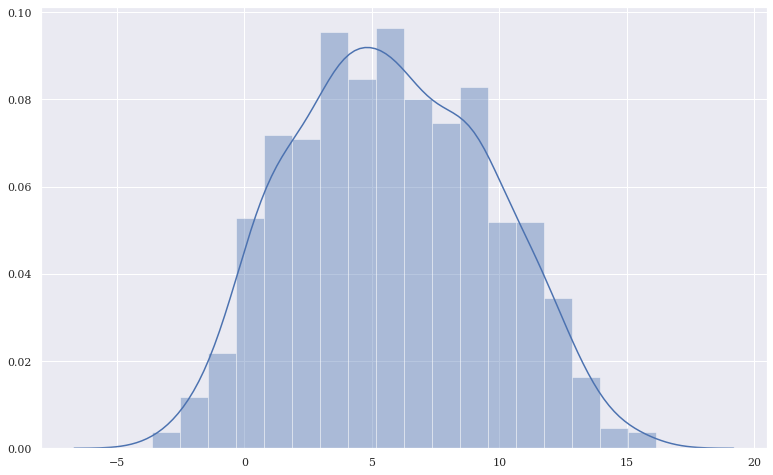

In [373]:
sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, size=1000))

Median

In [366]:
bounded_lognorm.median(mode, sigma, lower, upper)

array(5.7204538)

These do not work.

In [364]:
bounded_lognorm.mean(mode, sigma, lower, upper)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


5.8494089709916075

In [354]:
mean, var, skew, kurt = bounded_lognorm.stats(mode, sigma, lower, upper, moments='mvsk')

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


### How it works

First, we define a lognormal probability density function in terms of mode $m$ and standard deviation $\sigma$. If $\mu_N$ and $\sigma_N^2$ are the mean and variance of a normal distribution $N$, then the mode $m$ and variance $\sigma^2$ of the associated lognormal distribution are 

>$\begin{align}
       m & = exp(\mu_N - \sigma_N^2) \tag{1}\\
\sigma^2 & = (exp(\sigma_N^2)-1) \times exp(2\mu_N + \sigma_N ^2) \tag{2}
\end{align}$

Letting $g = exp(\sigma_N^2)$ and substituting into equation (2):

>$\begin{align} 
\sigma^2 & = (g-1) \times exp(2\mu_N + \sigma_N ^2) \\
         & = (g-1) \times exp(2\mu_N) \times exp(\sigma_N^2) \\ 
         & = (g-1) \times exp(2\mu_N) \times g \\
         & = g(g-1) \times exp(2\mu_N)  \tag{3}
\end{align}$ 

Rearrangeing equation (1) to solve for $\mu_N$ and plugging into the second expression above:

>$\begin{align} 
\mu_N & = \ln(m) + \sigma_N^2 \tag{4} \\ \\
exp(2\mu_N) & = exp(2(\ln(m)+\sigma_N^2)) \\
            & = exp(2\ln(m)+2\sigma_N^2) \\
            & = exp(2\ln(m))+ exp(2\sigma_N^2) \\
            & = exp(\ln(m))^2+ exp(\sigma_N^2)^2 \\
            & = m^2g^2 \\
\end{align}$ 

Substituting $m^2g^2$ into equation (3) and rearranging as a quartic equation:

>$\begin{align} 
\sigma^2 & = g(g-1) \times m^2g^2  \\
        & = g^3(g-1) \times m^2  \\
        & = (g^4 - g^3) \times m^2 \\ \\
      0 & = g^4 - g^3 -  \sigma^2/m^2 \tag{5}
\end{align}$ 

Rearrangeing equation equation (1) to solve for $\sigma_N$ in terms of $g$, the unique positive real root of equation (5):

>$\text{shape} = \sigma_N = \sqrt{\ln(g)} \tag{6}$

Solving for $exp(\mu_N)$ in terms of $g$:

>$\text{scale} = exp(\mu_N) = m \times g \tag{7}$

Equations (6) and (7) provide the shape and scale parameters, respectively, of the [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) implementation of the lognormal distribution.

_References_: 
1. https://en.wikipedia.org/wiki/Log-normal_distribution
2. https://math.stackexchange.com/questions/2003529/derive-mode-of-lognornormal-distribution
3. https://stackoverflow.com/questions/41464753

Here is an example with $m = 1$ and $\sigma = 1$. 

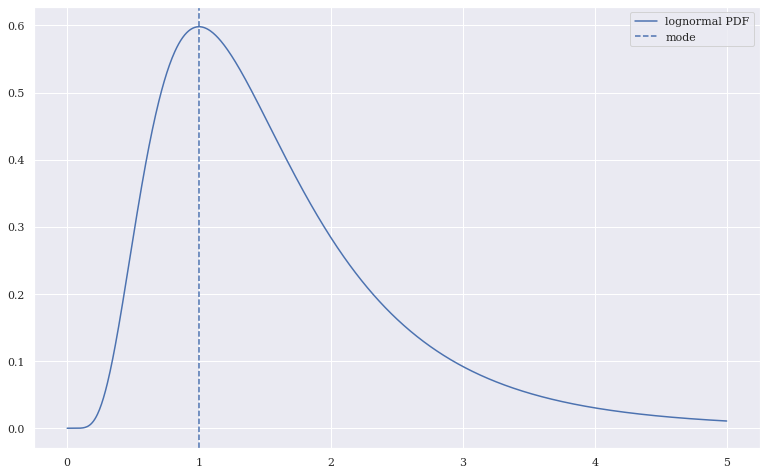

In [38]:
mode, sigma = 1, 1
lower, upper = 0, 5
shape, scale = lognorm_params(mode, sigma)

x = np.linspace(lower, upper, 1000)
y = lognorm.pdf(x, s=shape, loc=0, scale=scale)
sns.lineplot(x, y, label="lognormal PDF")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

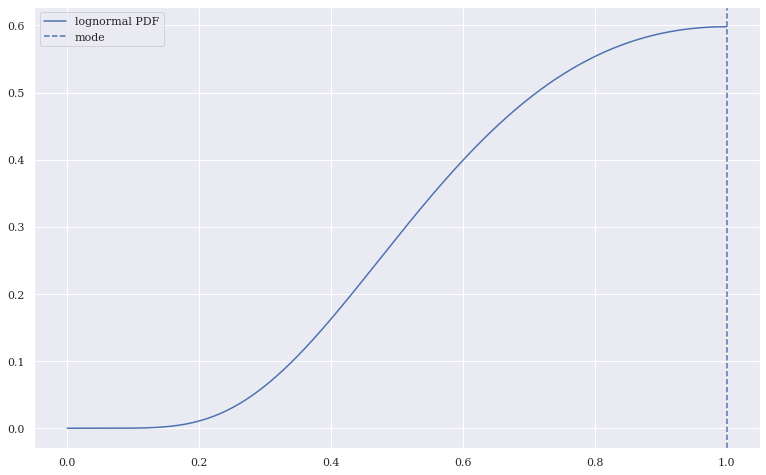

In [0]:
mode, sigma = 1, 1
lower, upper = 0, 5
shape, scale = lognorm_params(mode, sigma)

x = np.linspace(lower, mode, 1000)
y = lognorm.pdf(x, s=shape, loc=0, scale=scale)
sns.lineplot(x, y, label="lognormal PDF")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

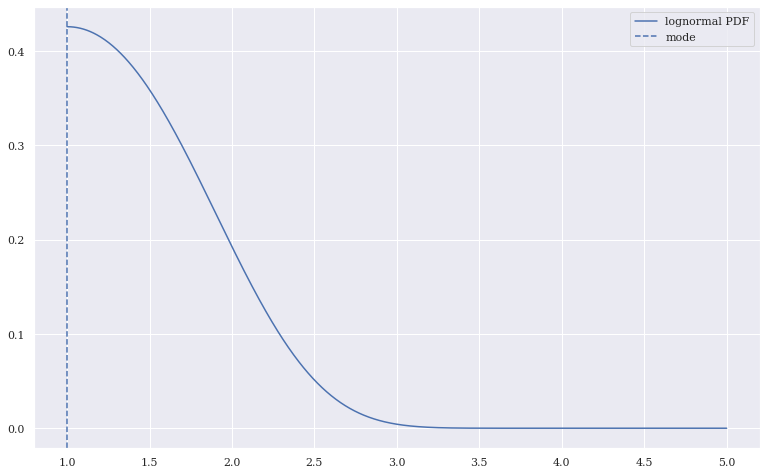

In [0]:
mode, sigma = 1, 1
lower, upper = 0, 5
shape, scale = lognorm_params(upper - mode, sigma)

x = np.linspace(mode, upper, 1000)
y = lognorm.pdf(upper - x, s=shape, loc=0, scale=scale)
sns.lineplot(x, y, label="lognormal PDF")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

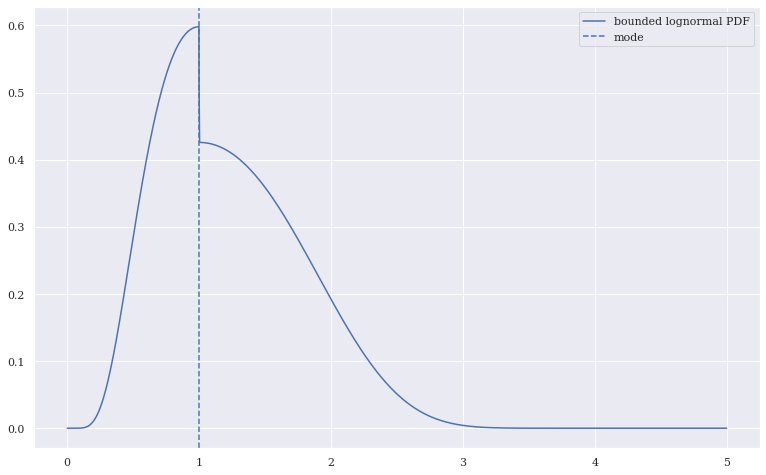

In [39]:
shape, scale = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm.pdf(x_left, s=shape, loc=0, scale=scale)

shape, scale = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm.pdf(upper - x_right, s=shape, loc=0, scale=scale)

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal PDF")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

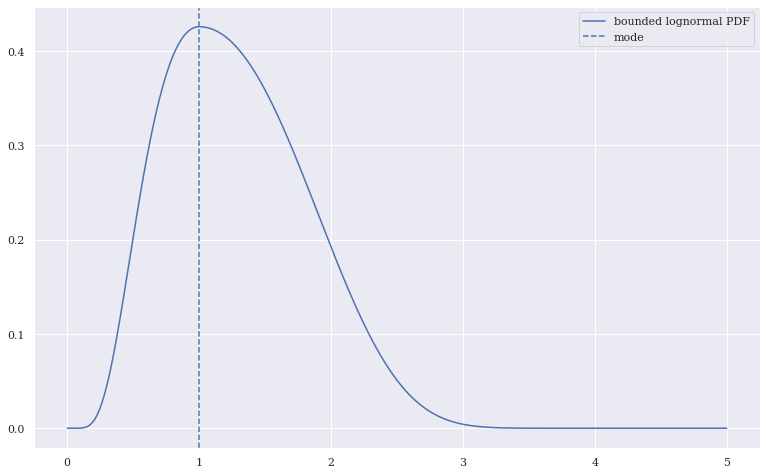

In [40]:
shape, scale = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm.pdf(x_left, s=shape, loc=0, scale=scale)

shape, scale = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm.pdf(upper - x_right, s=shape, loc=0, scale=scale)

shape, scale = lognorm_params(mode - lower, sigma)
y_left_at_mode = lognorm.pdf(mode, s=shape, loc=lower, scale=scale)

shape, scale = lognorm_params(upper - mode, sigma)
y_right_at_mode = lognorm.pdf(upper, s=shape, loc=mode, scale=scale)

left_scale = y_right_at_mode / y_left_at_mode

y_left = y_left * left_scale

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal PDF")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

### As the upper and lower bounds move away from the mode, the bounded_lognorm pdf more closely approximates the normal pdf.

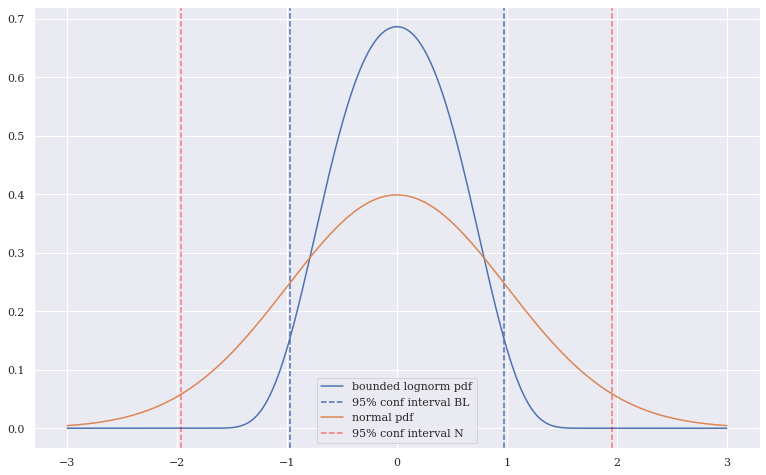

In [355]:
mode, sigma = 0, 1
spread = 2
lower = mode - spread
upper = mode + spread

x = np.linspace(-3, 3, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x,y, label='bounded lognorm pdf')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dashed', 
            label='95% conf interval BL')
plt.axvline(interval[1], ymin=0, linestyle='dashed')

y = norm.pdf(x, loc=mode, scale=sigma)
sns.lineplot(x,y, label='normal pdf')

interval2 = norm.interval(0.95, loc=mode, scale=sigma)
plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
            label='95% conf interval N')
plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

plt.legend()
plt.show()

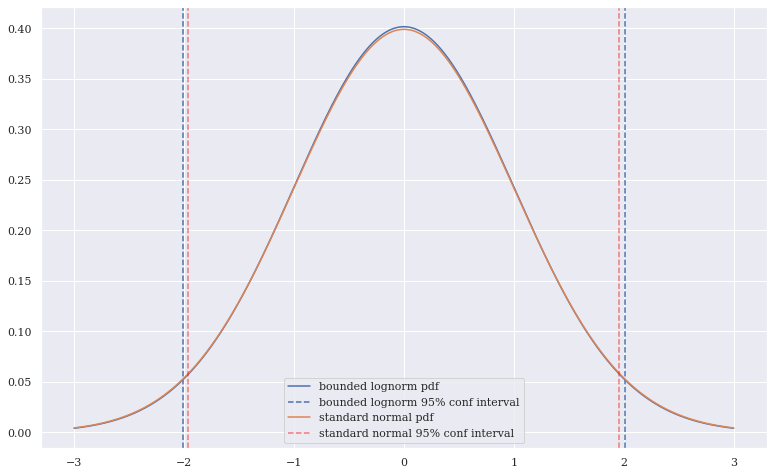

In [358]:
mode, sigma = 0, 1
spread = 200
lower = mode - spread
upper = mode + spread

x = np.linspace(-3, 3, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x,y, label='bounded lognorm pdf')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dashed', 
            label='bounded lognorm 95% conf interval')
plt.axvline(interval[1], ymin=0, linestyle='dashed')

y = norm.pdf(x, loc=mode, scale=sigma)
sns.lineplot(x,y, label='standard normal pdf')

interval2 = norm.interval(0.95, loc=mode, scale=sigma)
plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
            label='standard normal 95% conf interval')
plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

plt.legend()
plt.show()

### Bounded lognormal vs truncated normal distribution

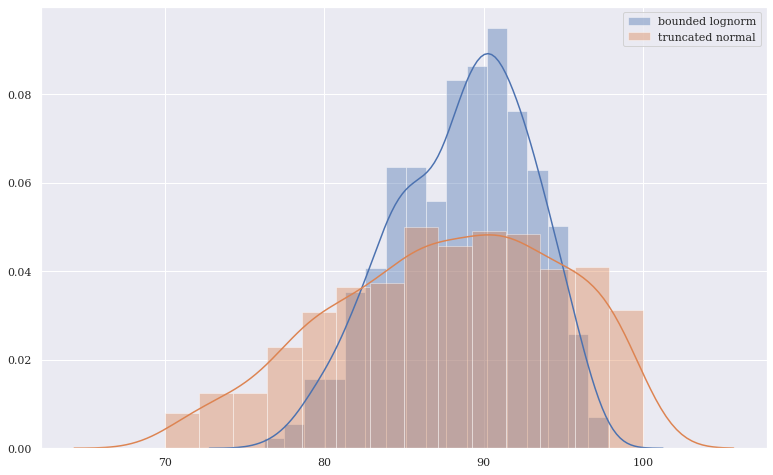

In [359]:
from scipy.stats import truncnorm

mode, sigma = 90, 10
lower, upper = 70, 100

sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, 
                                 lower=lower, upper=upper, size=1000),
             label='bounded lognorm')
sns.distplot(truncnorm.rvs((lower - mode) / sigma,  
                           (upper - mode) / sigma,
                           mode, sigma, size=1000),
             label='truncated normal')
plt.legend()
plt.show()